# PARCIAL GRUPAL 1

**Integrantes:** Ana Diaz, Richard Gonzalez, Jhon Villareal
#  PARTE I: DESARROLLO (60 PUNTOS)

---

##  Instrucciones Generales

Como grupo, hemos seleccionado y explorado una API para aplicar los conceptos vistos en clase.

| Pregunta | Respuesta |
| :--- | :--- |
| **¿Qué API seleccionaron?** | Riot Games API |
| **¿De qué trata? (Dominio/Finalidad)** | Permite obtener el historial detallado de cada jugador, enfocándose en estadísticas con campeones específicos del juego *League of Legends* (LoL). |
| **¿Por qué la eligieron?** | Interés en el manejo de grandes volúmenes de datos y la popularidad del juego, lo que garantiza una fuente rica y relevante de información. |

Aplicaremos el **ciclo de vida de un proyecto de ciencia de datos** hasta llegar a los primeros **Análisis Exploratorios de Datos (EDA)**.

---



## 1. Definición del Problema y Objetivos

**Problema:**  
Los jugadores y analistas de *League of Legends* necesitan comprender mejor las variables que influyen en la victoria o derrota de una partida (por ejemplo: el campeón elegido, la cantidad de oro obtenido o el nivel de experiencia).

**Objetivo general:**  
Analizar datos reales del *Riot Games API* para identificar patrones de desempeño y factores clave asociados con el éxito en las partidas.

**Objetivos específicos:**
1. Conectarse correctamente con la API de Riot Games y obtener datos reales de partidas.
2. Limpiar y transformar la información recibida.
3. Realizar análisis exploratorios y visualizaciones estadísticas de los resultados.


##  2. Adquisición de Datos

En esta sección se conecta la API, se obtiene información básica de jugadores y partidas, y se guarda una muestra de datos para análisis.


Celda de código: configuración e imports

In [6]:
import os, time, json, urllib.parse, requests
import pandas as pd
import matplotlib.pyplot as plt

#API_KEY = 'RGAPI-d78662bf-afa9-4e15-8dff-dbf67b6eef23'
API_KEY = 'RGAPI-c904d0a9-2e62-4355-9350-4cf1fcf13077'
HEADERS = {'X-Riot-Token': API_KEY}

if not API_KEY:
    print("Variable de entorno RIOT_API_KEY no definida")

Celda de código: obtener informacion de un jugador

In [8]:
def get_summoner_by_riot_id(game_name, tag_line, routing_region='asia', platform='kr'):
    game_name_enc = urllib.parse.quote(game_name)
    tag_line_enc = urllib.parse.quote(tag_line)
    url = f'https://{routing_region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_name_enc}/{tag_line_enc}'
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    account_data = r.json()
    puuid = account_data['puuid']
    
    url2 = f'https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/by-puuid/{puuid}'
    r2 = requests.get(url2, headers=HEADERS)
    r2.raise_for_status()
    return r2.json()

summoner = get_summoner_by_riot_id("Hide on bush", "KR1", routing_region='asia', platform='kr')
summoner

{'puuid': '2no2DfPxOMX0rJ_IUyu8BruJAUP58vfRdX0PhhGgJBePDRlgev43Pt_0bThGy6gm_VaG1NF_LZntsA',
 'profileIconId': 6,
 'revisionDate': 1759935176000,
 'summonerLevel': 863}

El código anterior obtiene la información básica de un jugador a partir de su nombre.  
Riot API devuelve identificadores como `puuid` y `id`, necesarios para buscar su historial de partidas.


In [9]:
def get_summoner_by_riot_id(game_name, tag_line, routing_region='asia', platform='kr'):
    game_name_enc = urllib.parse.quote(game_name)
    tag_line_enc = urllib.parse.quote(tag_line)
    url = f'https://{routing_region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_name_enc}/{tag_line_enc}'
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    account_data = r.json()
    puuid = account_data['puuid']
    
    url2 = f'https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/by-puuid/{puuid}'
    r2 = requests.get(url2, headers=HEADERS)
    r2.raise_for_status()
    return r2.json()

summoner = get_summoner_by_riot_id("Hide on bush", "KR1", routing_region='asia', platform='kr')
summoner

def get_match_ids(puuid, count=20, region='asia'):
    url = f'https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?count={count}'
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    return r.json()

match_ids = get_match_ids(summoner['puuid'], count=10, region='asia')
match_ids

['KR_7858254806',
 'KR_7858151244',
 'KR_7858019563',
 'KR_7857352690',
 'KR_7856448015',
 'KR_7856357576',
 'KR_7856281659',
 'KR_7856196441',
 'KR_7855895357',
 'KR_7855800422']

### Recolección de partidas y guardado de muestra

Celda de código (descargar detalles)

In [10]:
def get_match_details(match_id, region='asia'):
    url = f'https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}'
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    return r.json()

matches = [get_match_details(mid, region='asia') for mid in match_ids]

with open('matches_sample.json', 'w') as f:
    json.dump(matches, f, indent=2)

##  3. Procesamiento y Limpieza de Datos

Se seleccionan las variables más relevantes de cada participante y se transforma la información en un formato tabular.


In [11]:
records = []

for match_id in match_ids:
    match = get_match_details(match_id, region='asia')
    info = match['info']

    for p in info['participants']:
        records.append({
            "matchId": match['metadata']['matchId'],
            "puuid": p['puuid'],  # 🔹 usa esto para mapear luego
            "summonerName": p.get('summonerName', None),
            "championName": p['championName'],
            "kills": p['kills'],
            "deaths": p['deaths'],
            "assists": p['assists'],
            "win": p['win'],
            "goldEarned": p['goldEarned'],
            "damageDealtToChampions": p['totalDamageDealtToChampions']
        })


df = pd.DataFrame(records)
df.to_csv('matches_sample.csv', index=False)
df.head()

def get_player_winrate(puuid, match_ids, region='asia'):
    wins = 0
    total = 0
    
    for match_id in match_ids:
        match = get_match_details(match_id, region)
        info = match['info']
        
        # Buscar el participante con ese puuid
        for p in info['participants']:
            if p['puuid'] == puuid:
                total += 1
                if p['win']:
                    wins += 1
                break  # No seguir revisando los demás
    if total == 0:
        return 0
    return round((wins / total) * 100, 2)

puuid = summoner['puuid']
winrate = get_player_winrate(puuid, match_ids, region='asia')
print(f"Winrate de 'Hide on Bush': {winrate}%")


Winrate de 'Hide on Bush': 70.0%


Se oberva que la columna summonerName está vacía, así que podemos eliminarla

In [18]:
##df = df.drop(columns=['summonerName'])
df.head(10)

,matchId,puuid,championName,kills,deaths,assists,win,goldEarned,damageDealtToChampions
0,KR_7858254806,kACE1Fx4R6Xu1K4_8Q7Z4uOxhdRmMBsi_y1XmeHdCgDot9...,RekSai,5,3,0,True,9521,17869
1,KR_7858254806,I7KPt2KkCfR4JMhY2GDjc5g0-LZg5_1wnICS7RddX5dXa-...,LeeSin,7,2,9,True,10084,13383
2,KR_7858254806,2no2DfPxOMX0rJ_IUyu8BruJAUP58vfRdX0PhhGgJBePDR...,Jayce,6,4,7,True,9400,17487
3,KR_7858254806,yYI7Eu6_VZ3jzsTS2myYvCu5fXwSxuw2w_YltEOd7nQRxe...,Ziggs,4,3,8,True,10385,18399
4,KR_7858254806,i563qEeCFKxSlsKAZZUD-wcMWDD5Pblk3felzeNcKWnRBt...,Pyke,2,5,11,True,6761,9376
5,KR_7858254806,VZpoWLHA8RRL81RGsCWQsWtQ85laktqav6rtrpbsM13846...,KSante,0,5,5,False,7224,18732
6,KR_7858254806,UnH1HTovykr1UU-3C8PzbypG89JQhJxElywqP-IDPYoAZ0...,MonkeyKing,4,4,2,False,8793,9748
7,KR_7858254806,JPD5VLu-0vLjRlhNkICx59y53_J5wsl9UTe3cDT6onkBgy...,Zoe,4,2,8,False,7971,19503
8,KR_7858254806,VMR7sqAUhT_5rrg7gvOrHSXQ8Bgxdh3tWpdySrSYOVyXCv...,Kaisa,7,4,2,False,9472,12717
9,KR_7858254806,ssuahJeJF15cA5n5gEZTYuub3sHSGDyiksIX138lQgG8b_...,Rakan,2,9,7,False,5882,5042


##  4. Análisis Exploratorio de Datos (EDA)


### Descripción de las variables del DataFrame
| **Variable**             | **Tipo de dato** | **Descripción**                                                                                                                                                               |
| ------------------------ | ---------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `puuid`                | `string`         | ID de jugador. Nos permite obtener datos de un jugador especifico en la partida.        |
| `matchId`                | `string`         | Identificador único de la partida. Este ID permite acceder a la información completa del juego y se repite para los 10 jugadores que participaron en la misma partida.        |
| `championName`           | `string`         | Nombre del campeón seleccionado por el jugador durante la partida (por ejemplo: *Ahri*, *Yasuo*, *Lee Sin*).                                                                  |
| `kills`                  | `int`            | Número total de enemigos eliminados por el jugador. Representa su capacidad ofensiva.                                                                                         |
| `deaths`                 | `int`            | Número de veces que el jugador murió durante la partida. Indica su vulnerabilidad o exposición al riesgo.                                                                     |
| `assists`                | `int`            | Cantidad de eliminaciones en las que el jugador participó asistiendo a un aliado. Refleja cooperación y trabajo en equipo.                                                    |
| `win`                    | `bool`           | Valor booleano que indica si el jugador ganó (`True`) o perdió (`False`) la partida. Puede considerarse como la **variable dependiente (objetivo)** en análisis de desempeño. |
| `goldEarned`             | `int`            | Total de oro acumulado por el jugador, proveniente de súbditos, campeones enemigos, estructuras u objetivos. Mide la cantidad de recursos obtenidos.                          |
| `damageDealtToChampions` | `int`            | Daño total infligido por el jugador a otros campeones enemigos durante la partida. Es un indicador de impacto ofensivo.                                                       |


### Estadísticas Descriptivas:

In [23]:
df.describe()

,kills,deaths,assists,goldEarned,damageDealtToChampions
count,112.000000,112.000000,112.000000,112.000000,112.000000
mean,5.410714,5.419643,7.035714,10882.258929,23212.705357
std,3.814514,2.598123,4.891487,3258.096158,13572.795295
min,0.000000,0.000000,0.000000,4335.000000,4039.000000
25%,3.000000,3.750000,3.000000,8611.750000,13929.750000
50%,5.000000,5.500000,6.000000,10826.000000,19716.000000
75%,7.000000,7.000000,10.000000,13114.250000,29325.000000
max,17.000000,13.000000,24.000000,20900.000000,80068.000000


#### Variables Categóricas:
El data frame contiene dos variables categóricas: 
1. championName
2. win

Calcular frecuencia de la variable championName:

In [27]:
df['championName'].value_counts()
def get_champions_played(puuid, match_ids, region='asia'):
    champions = []

    for match_id in match_ids:
        match = get_match_details(match_id, region)
        info = match['info']

        # Buscar al jugador dentro de los participantes
        for p in info['participants']:
            if p['puuid'] == puuid:
                champions.append(p['championName'])
                break  # salimos del bucle una vez encontrado el jugador

    return champions

puuid = summoner['puuid']
champions = get_champions_played(puuid, match_ids, region='asia')

print(f"Campeones jugados por 'Hide on Bush':")
print(champions)


Campeones jugados por 'Hide on Bush':
['Jayce', 'Lissandra', 'Leblanc', 'Taliyah', 'Azir', 'Azir', 'Aurora', 'Yone', 'Darius', 'Jayce']


Frecuencia de la variable win:

In [37]:
from collections import defaultdict

def get_winrate_by_champion(puuid, match_ids, region='asia'):
    stats = defaultdict(lambda: {"wins": 0, "total": 0})

    for match_id in match_ids:
        match = get_match_details(match_id, region)
        info = match['info']

        # Buscar al jugador
        for p in info['participants']:
            if p['puuid'] == puuid:
                champ = p['championName']
                stats[champ]["total"] += 1
                if p['win']:
                    stats[champ]["wins"] += 1
                break

    # Calcular winrate
    results = []
    for champ, s in stats.items():
        winrate = round((s["wins"] / s["total"]) * 100, 2)
        results.append({
            "championName": champ,
            "gamesPlayed": s["total"],
            "wins": s["wins"],
            "winrate": winrate
        })

    # Ordenar por número de partidas jugadas
    results.sort(key=lambda x: x["gamesPlayed"], reverse=True)
    return results
puuid = summoner['puuid']
champion_stats = get_winrate_by_champion(puuid, match_ids, region='asia')

import pandas as pd
df_champs = pd.DataFrame(champion_stats)
print(df_champs)



  championName  gamesPlayed  wins  winrate
0        Jayce            2     2    100.0
1         Azir            2     2    100.0
2    Lissandra            1     1    100.0
3      Leblanc            1     0      0.0
4      Taliyah            1     0      0.0
5       Aurora            1     0      0.0
6         Yone            1     1    100.0
7       Darius            1     1    100.0


##  5. Análisis Básico con Visualizaciones


**Top 10 campeones por winrate** Esta tabla de frecuencia nos muestra los campeones que han obtenido más victorias

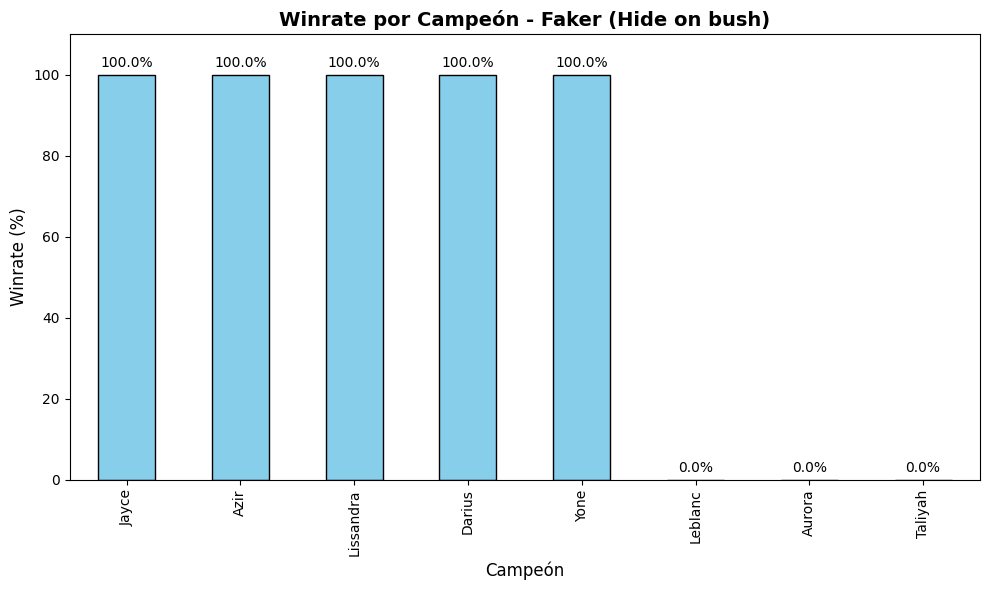

In [38]:
df_champs = df_champs.sort_values(by='winrate', ascending=False)

# 🎨 Crear la gráfica de barras con pandas y matplotlib
ax = df_champs.plot(
    kind='bar',
    x='championName',
    y='winrate',
    color='skyblue',
    legend=False,
    figsize=(10, 6),
    edgecolor='black'
)

# 🏷️ Personalizar el gráfico
plt.title("Winrate por Campeón - Faker (Hide on bush)", fontsize=14, fontweight='bold')
plt.xlabel("Campeón", fontsize=12)
plt.ylabel("Winrate (%)", fontsize=12)
plt.ylim(0, 110)

# 🧩 Mostrar porcentaje encima de cada barra
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2, p.get_height() + 2),
        ha='center',
        fontsize=10
    )

# 🧠 Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

**Comparacion de oro recibido por roles** Estas graficas nos muestran el oro recolectado por jugador en un rol especifico, comparandolo con otros jugadores en el mismo rol

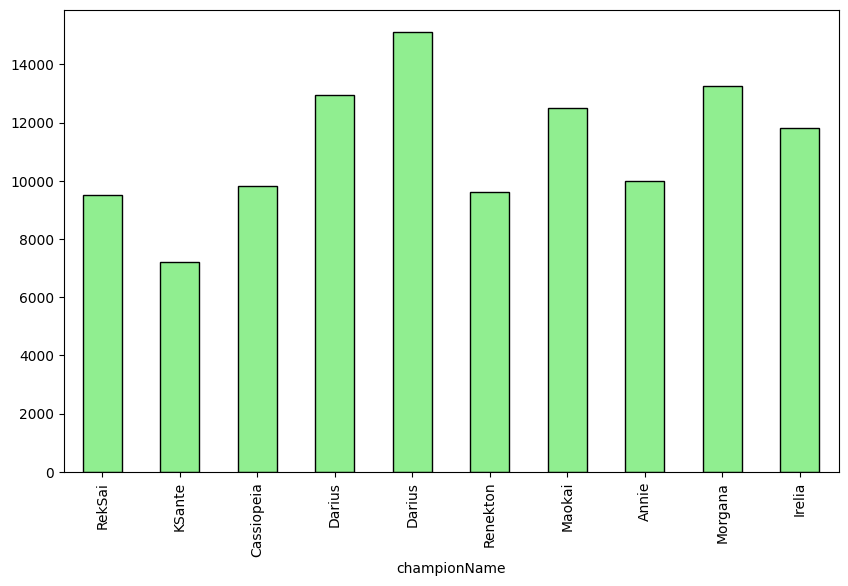

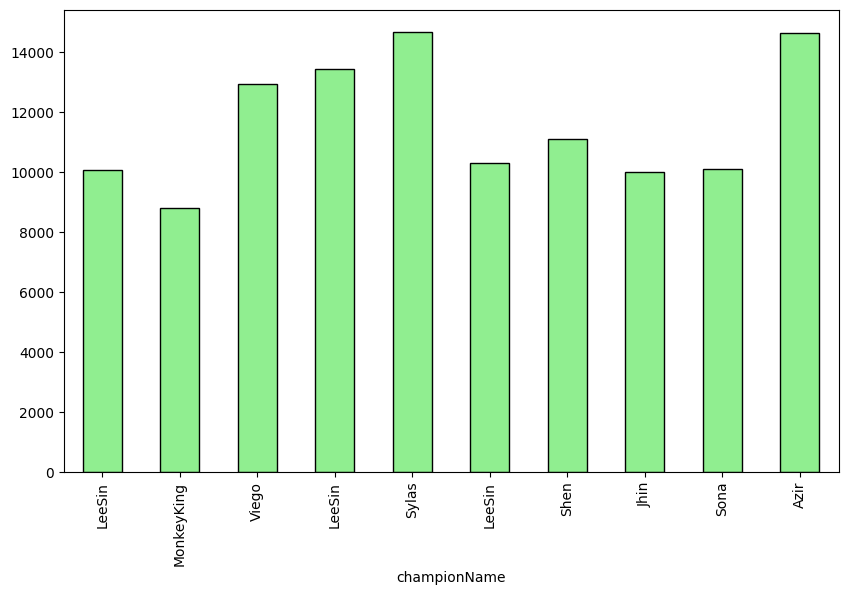

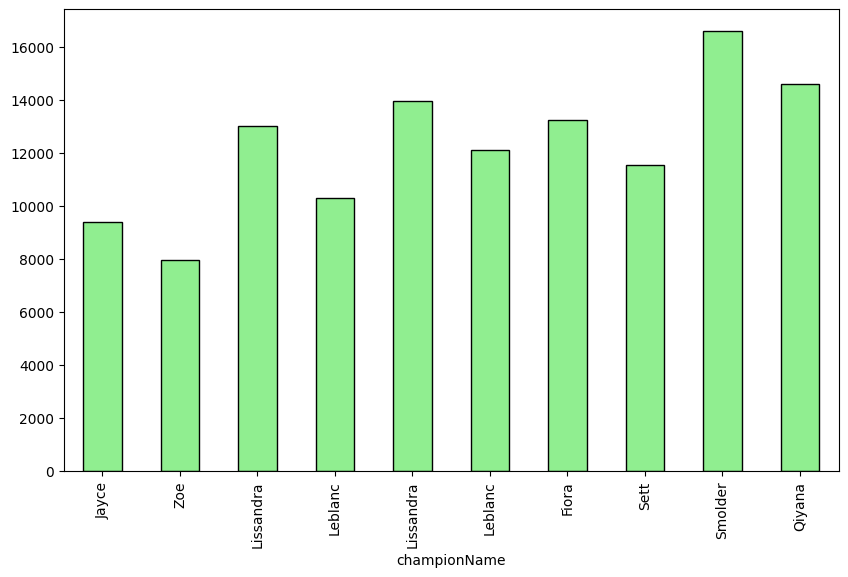

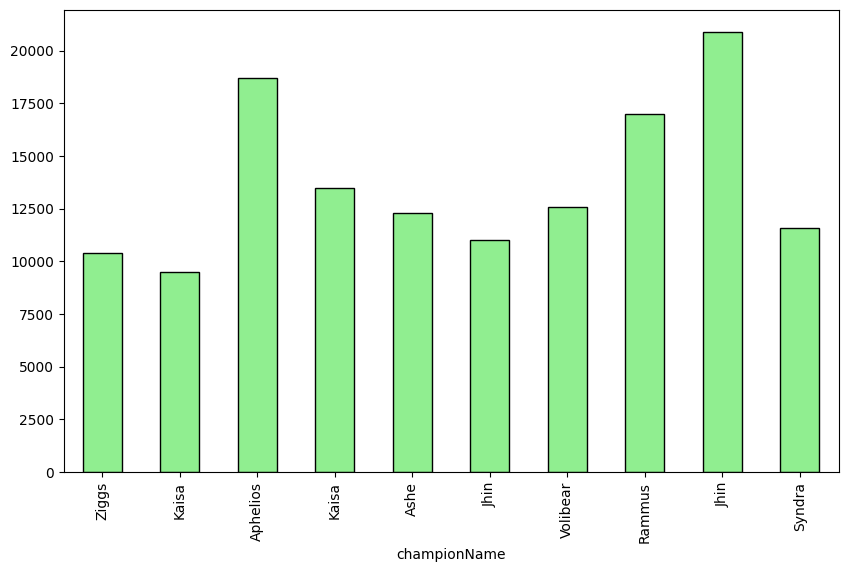

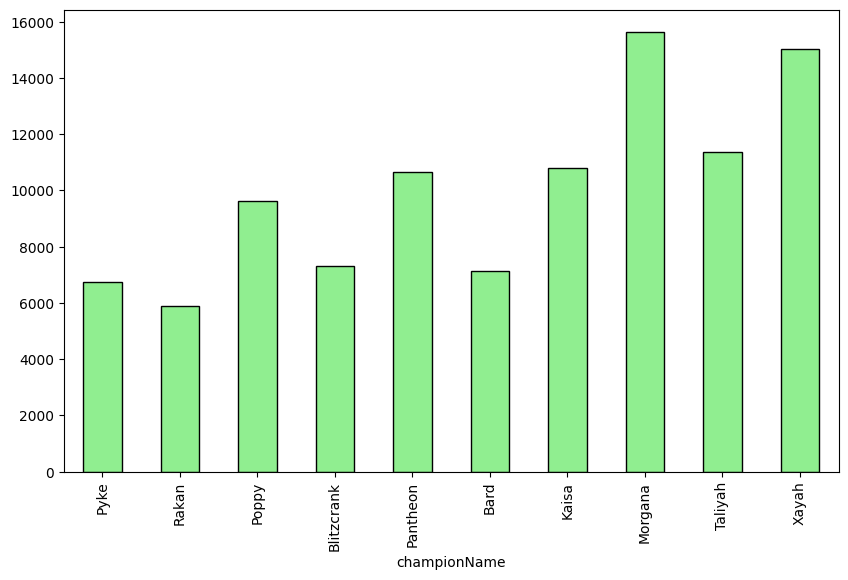

In [34]:
# Oro ganado por jugador, comparación entre campeones entre los primeros 10 jugadores
# promedio de cada 5 jugadores en la lista

df_top = df.iloc[::5].reset_index(drop=True)      # Rol de top
df_top['goldEarned'].rolling(window=5).mean().head(10)
df_jungle = df.iloc[1::5].reset_index(drop=True)  # Rol de jungla
df_jungle['goldEarned'].rolling(window=5).mean().head(10)
df_mid = df.iloc[2::5].reset_index(drop=True)     # Rol de mid
df_mid['goldEarned'].rolling(window=5).mean().head(10)
df_adc = df.iloc[3::5].reset_index(drop=True)     # Rol de tirador
df_adc['goldEarned'].rolling(window=5).mean()
df_supp = df.iloc[4::5].reset_index(drop=True)    # Rol de soporte

ax = df_top.head(10).plot(
    kind='bar',         
    x='championName',
    y='goldEarned',
    color='lightgreen',
    legend=False,
    figsize=(10, 6),
    edgecolor='black'
)
ax = df_jungle.head(10).plot(
    kind='bar',         
    x='championName',
    y='goldEarned',
    color='lightgreen',
    legend=False,
    figsize=(10, 6),
    edgecolor='black'
)
ax = df_mid.head(10).plot(
    kind='bar',         
    x='championName',
    y='goldEarned',
    color='lightgreen',
    legend=False,
    figsize=(10, 6),
    edgecolor='black'
)
ax = df_adc.head(10).plot(
    kind='bar',         
    x='championName',
    y='goldEarned',
    color='lightgreen',
    legend=False,
    figsize=(10, 6),
    edgecolor='black'
)
ax = df_supp.head(10).plot(
    kind='bar',         
    x='championName',
    y='goldEarned',
    color='lightgreen',
    legend=False,
    figsize=(10, 6),
    edgecolor='black'
)
    

**Top 10 campeones más jugados:** Esta tabla de frecuencia nos muestra los campeones más populares entre los jugadores

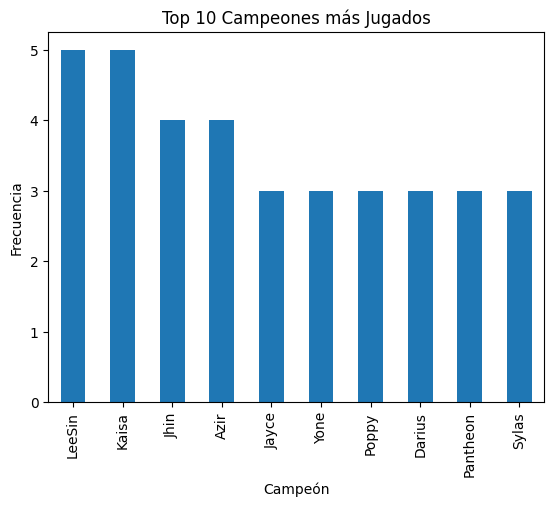

In [25]:
df['championName'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Campeones más Jugados")
plt.xlabel("Campeón")
plt.ylabel("Frecuencia")
plt.show()

- **Análisis del gráfico**: Se muestra un favoritismo hacia los campeones LeeSin y Kaisa

**Histograma de kills por jugador:** Muestra cuántos jugadores han hecho una cantidad determinada de kills

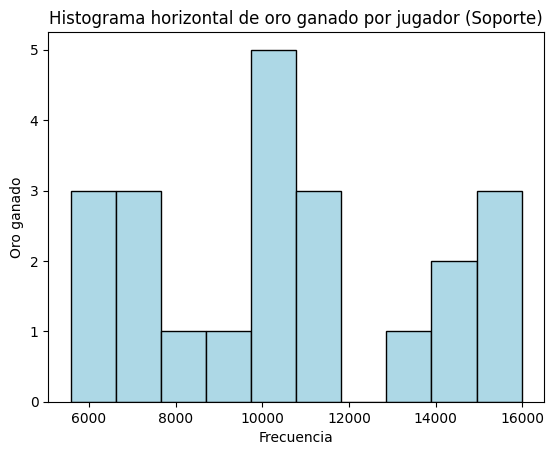

In [40]:

plt.hist(df_supp['goldEarned'], bins=10, color='lightblue', edgecolor='black')
plt.title("Histograma horizontal de oro ganado por jugador (Soporte)")
plt.xlabel("Frecuencia")
plt.ylabel("Oro ganado")
plt.show()

- **Análisis del Gráfico:** La mayoría de los jugadores con rol de soporte hacen alrededor de 10000 de oro en una partida promedio

**Relación entre kills y el dinero obtenido:** Muestra la correlación entre las kills y el dinero obtenido en una partida

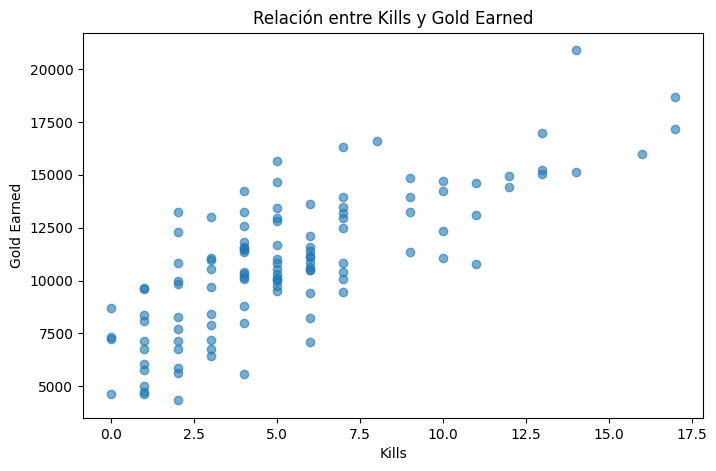

In [27]:
plt.figure(figsize=(8,5))
plt.scatter(df['kills'], df['goldEarned'], alpha=0.6)
plt.xlabel("Kills")
plt.ylabel("Gold Earned")
plt.title("Relación entre Kills y Gold Earned")
plt.show()


- **Análisis del gráfico:** se observa una correlación positiva entre las kills y el dinero ganado

**Relación entre el daño recibido y el oro ganado:** Muestrá cómo es la relación entre el daño inflingido vs el dinero ganado:

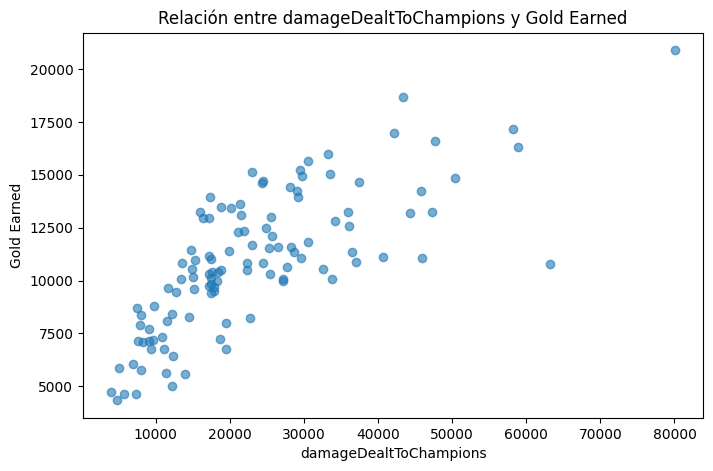

In [28]:
plt.figure(figsize=(8,5))
plt.scatter(df['damageDealtToChampions'], df['goldEarned'], alpha=0.6)
plt.xlabel("damageDealtToChampions")
plt.ylabel("Gold Earned")
plt.title("Relación entre damageDealtToChampions y Gold Earned")
plt.show()


- **Análisis del gráfico:** se observa una correlación positiva entre las damageDealtToChampions y el dinero ganado

##  6. Conclusiones

- Los datos obtenidos permitieron analizar distintas métricas del rendimiento de los jugadores.  
- Se observó que los campeones con mayor *winrate* fueron Lee Sin, Kaisa y Jhon.  
- Se evidenció una relación positiva entre el oro ganado y la cantidad de daño infligido.  
- Como limitación, el número de partidas fue reducido debido a los **rate limits** de la API de Riot Games.


##  PARTE II: APORTACIÓN INDIVIDUAL

**Integrante:** Richard Gonzalez  

**Aportación:**  
- Implementé las funciones para conectarse con la API (`get_summoner_by_name`, `get_match_ids`, `get_match_detail`).  
- Realicé gráficos de análisis exploratorio (winrate por campeón).  

**Relación con los objetivos del proyecto:**  
Mi trabajo permitió generar la base de datos necesaria para el análisis y las visualizaciones, cumpliendo con los objetivos de adquisición, limpieza y análisis inicial de los datos.

**Integrante:** Ana Díaz 

**Aportación:**  
- Eliminación de columnas vacías
- Descripción de las variables obtenidas
- Frecuencia de variables categóricas y análisis visual.  

**Relación con los objetivos del proyecto:**  
Ajusté el data frame para tener información relevante y realicé ciertos análisis de los datos obtenidos.

**Integrante:** Jhon Villarreal

**Aportación:**  
- Extraje y limpié los datos de las partidas obtenidas.  
- Realicé gráficos de análisis exploratorio (winrate por campeón).  
